In [2]:
import pandas 
import numpy

import matplotlib.pyplot
import seaborn

import networkx

from scipy.stats import ranksums

from utils import parse_interactome, parse_causal_genes

In [3]:
def parse_scores(scores_file, causal_genes):
    # load scores
    scores = {}

    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            gene, score = line_splitted
            # skip causal genes
            if causal_genes.get(gene) == 1:
                continue
            scores[gene] = float(score)

    return scores

In [4]:
def parse_leave_one_out(scores_file):
    # load left-out scores
    scores_left_out = {}

    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            gene, score = line_splitted
            scores_left_out[gene] = float(score)
        
    return scores_left_out

In [5]:
def concatenate_scores(scores, scores_left_out):
    df_scores = pandas.DataFrame.from_dict(scores, 
                                       orient='index', 
                                       columns=['score'])
    df_scores['group'] = "non-causal"

    df_scores_left_out = pandas.DataFrame.from_dict(scores_left_out, 
                                                    orient='index', 
                                                    columns=['score'])

    df_scores_left_out['group'] = 'left-out'

    # concatenate dataframes for comparison
    df_compare = pandas.concat([df_scores, df_scores_left_out])

    stat, p_value = ranksums(df_scores['score'].values, df_scores_left_out['score'].values)

    return df_compare, p_value

In [6]:
def causal_genes_at_distance(dict_distances, node, d):
    try:
        return len([dist for dist in dict_distances.get(node).values() if dist == d])
    except:
        return 0

In [7]:
def geneName_to_ENSG(genes_file):
    genes = {}

    f = open(genes_file, 'r')
    
    # skip header
    next(f)

    for line in f:
        line_splitted = line.rstrip().split('\t')
        gene_name, ENSG = line_splitted

        genes[gene_name] = ENSG
    
    return genes

#### Load and parse the necessary data

In [8]:
PHENOTYPE = "MMAF"

In [9]:
interactome, genes = parse_interactome(interactome_file="/home/kubicaj/calc/input/Interactome_human.sif")

causal_genes = parse_causal_genes(causal_genes_file="/home/kubicaj/calc/input/causalGenes_allPhenotypes.csv",
                                  canonical_genes_file="/home/kubicaj/calc/input/canonicalGenes.tsv",
                                  genes=genes)

In [152]:
# find distances between MMAF and non-MMAF genes
dict_distances = {}
longest_distance = 0

nonCausal_genes_list = [k for k, v in causal_genes.items() if v == 0]
causal_genes_list = [k for k, v in causal_genes.items() if v == 1]

for source_node in nonCausal_genes_list:
    dict_tmp = {}

    for target_node in causal_genes_list:
        try:
            distance = networkx.shortest_path_length(interactome, source_node, target_node)
            dict_tmp[target_node] = distance

            if distance > longest_distance:
                longest_distance = distance
        except:
            continue

    dict_distances[source_node] = dict_tmp

print(f"Longest distance between {PHENOTYPE} and non-{PHENOTYPE} gene: {longest_distance}")

Longest distance between MMAF and non-MMAF gene: 10


### Analyze canonical centralities

In [25]:
def parse_centrality_scores(scores_file):
    # load scores
    scores_causal = {}
    scores_nonCausal = {}

    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            gene, score = line_splitted
            # skip causal genes
            if causal_genes.get(gene) == 0:
                scores_nonCausal[gene] = float(score)
            else:
                scores_causal[gene] = float(score)
    return scores_causal, scores_nonCausal

In [27]:
def concatenate_centrality_scores(scores_causal, scores_nonCausal):
    df_causal = pandas.DataFrame.from_dict(scores_causal, 
                                       orient='index', 
                                       columns=['score'])
    df_causal['group'] = "causal"

    df_nonCausal = pandas.DataFrame.from_dict(scores_nonCausal, 
                                            orient='index', 
                                            columns=['score'])

    df_nonCausal['group'] = 'non-causal'

    # concatenate dataframes for comparison
    df_compare = pandas.concat([df_causal, df_nonCausal])

    stat, p_value = ranksums(df_causal['score'].values, df_nonCausal['score'].values)

    return df_compare, p_value

#### Analyze degree centrality

In [26]:
scores_DC_causal, scores_DC_nonCausal = parse_centrality_scores("/home/kubicaj/calc/output/scores_DC.tsv")

In [28]:
df_compare, p_value = concatenate_centrality_scores(scores_DC_causal, scores_DC_nonCausal)

(0.0, 0.01)

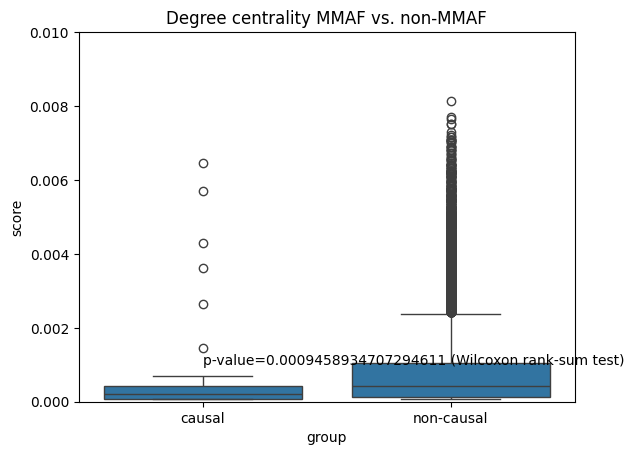

In [29]:
# plot
seaborn.boxplot(data=df_compare, x='group', y='score')
matplotlib.pyplot.text(0, 0.001, s=f"p-value={p_value} (Wilcoxon rank-sum test)")
matplotlib.pyplot.title(f"Degree centrality MMAF vs. non-MMAF")
matplotlib.pyplot.ylim(0, 0.01)

#### Analyze betweenness centrality

In [30]:
scores_BC_causal, scores_BC_nonCausal = parse_centrality_scores("/home/kubicaj/calc/output/scores_BC.tsv")

In [31]:
df_compare, p_value = concatenate_centrality_scores(scores_BC_causal, scores_BC_nonCausal)

(0.0, 0.01)

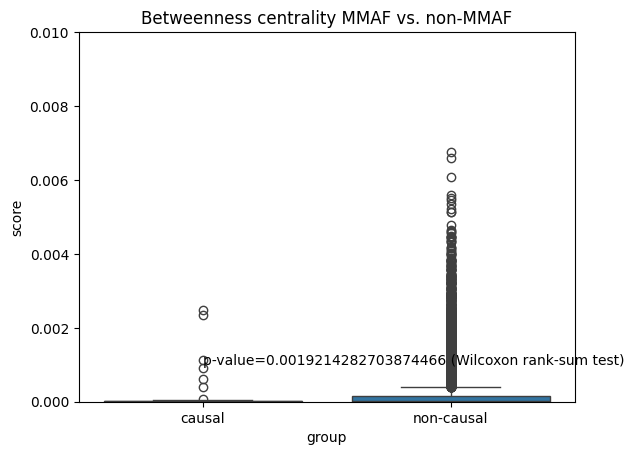

In [32]:
# plot
seaborn.boxplot(data=df_compare, x='group', y='score')
matplotlib.pyplot.text(0, 0.001, s=f"p-value={p_value} (Wilcoxon rank-sum test)")
matplotlib.pyplot.title(f"Betweenness centrality MMAF vs. non-MMAF")
matplotlib.pyplot.ylim(0, 0.01)